In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# fake data for testing
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.5, random_state=42)

print(X.shape)
print(y.shape)
print(f'Labels: {np.unique(y)}')

(1000, 2)
(1000,)
Labels: [0 1]


In [3]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (800, 2)
y_train.shape = (800,)
X_test.shape = (200, 2)
y_test.shape = (200,)


In [4]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Text(0.5, 1.0, 'Scatter plot: Training Samples')

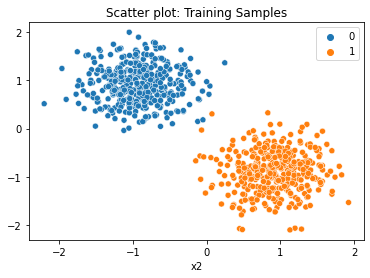

In [5]:
import seaborn as sns

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)
plt.xlabel('x1')
plt.xlabel('x2')
plt.title('Scatter plot: Training Samples')

In [6]:
from typing import Tuple

import numpy as np
from numpy import ndarray

from sklearn.base import BaseEstimator, ClassifierMixin

In [12]:

class LogisticRegression_teste(ClassifierMixin, BaseEstimator):
    """Our Logistic Regression implemented from scratch."""
    
    
    #### Inicializa a classe com os parametros default
    def __init__(self, 
                 learning_rate : float = 0.001,
                 n_epochs : int = 1000, 
                 random_state : int = 42):
        """
        Parameters
        ----------
        learning_rate : float, default=0.001
            Learning rate.
        n_epochs : int, default=1000
            Number of epochs for training (convergence stop).
        random_state : int, default=42
            Seed used for generating random numbers.
        """
        
        # Define alguns critérios básicos para funcionamento correto da classe
        # Caso os critérios não sejam satisfeitos retorna uma string de erro
        # Sintaxe:
        # assert (regra) operador_logico (regra) , string do erro
        assert (learning_rate is not None) and (learning_rate > 0.0), \
        f'Learning rate must be > 0. Passed: {learning_rate}'
        
        assert (n_epochs is not None) and (n_epochs > 0), \
        f'Number of epochs must be > 0. Passed: {n_epochs}'
        
        # public ==> todo mundo tem acesso para leitura e escrita direta
        # private ==> apenas a classe tem acesso para leitura e escrita direta
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.random_state = random_state
        
        # parameters to be trained/learned
        self.__w = None  # weight array
        self.__b = None  # bias
            
    # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):
        msg = f'Learning rate: {self.learning_rate}\n' \
              f'Number of epochs: {self.n_epochs}\n' \
              f'Random state: {self.random_state}\n\n' \
              f'Trained?: {self.is_fitted()}\n'
        return msg
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def coef_(self) -> ndarray:
        """Return the weight matrix (learned parameters) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def intercept_(self) -> float:
        """Return the bias (learned intercepet) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
    
    
    def is_fitted(self) -> bool:
        return self.__w is not None
    
    
    def __sigmoid(self, z: ndarray) -> ndarray:
        return 1 / (1 + np.e ** (-z))
    
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15):
        '''Return the log loss for a given estimation and ground-truth (true labels).
        
        log is undefined for 0. Consequently, the log loss is undefined for `p_hat=0` (because of log(p_hat)) and `p_hat=1` (because of ln(1 - p_hat)).
        To overcome that, we clipped the probabilities to max(eps, min(1 - eps, p_hat)), where `eps` is a tiny constant. 

        
        Parameters
        ----------
        y : ndarray, shape (n_samples,)
            True labels of input samples.
        p_hat : ndarray
            Estimated probabilities of input samples.
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        '''
        
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        # shape: (n_samples,)
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()
        
        return log_loss
    
    
    def __gradient(self, X: ndarray, y: ndarray, p_hat: ndarray) -> Tuple[ndarray, float]:
        '''Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray, shape (n_samples,)
            Estimated probabilities.
        
        Returns
        -------
        Tuple[ndarray, float]: 
            Tuple with:
            - a numpy array of shape (n_features,) containing the partial derivatives w.r.t. the weights; and
            - a float representing the partial derivative w.r.t. the bias.
        '''
        # X.shape: (n_samples, n_features)
        # y.shape == p_hat.shape: (n_samples,)
        n_samples = X.shape[0]
        
        error = p_hat - y  # shape (n_samples,)
        grad_w = np.dot(error, X) / n_samples  # shape (n_features,)
        grad_b = error.mean()  # float
        
        return grad_w, grad_b


    def fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        '''Train a Logistic Regression classifier.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        verbose: int, default=0
            Verbose flag. Print training information every `verbose` iterations.
            
        Returns
        -------
        self : object
            Returns self.
        '''
        ### CHECK INPUT ARRAY DIMENSIONS
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        assert y.ndim == 1, f'y must be 1D. Passed: {y.ndim}'
        assert X.shape[0] == y.shape[0], \
            f'X.shape[0] should be equal to y.shape[0], instead: {X.shape[0]} != {y.shape[0]}'
        # alternatively
        # X, y = check_X_y(X, y)

        ### SETTING SEED
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape

        ### PARAMETER INITIALIZATION
        # return values from the “standard normal” distribution.
        w = np.random.randn(n_features)  # shape: (n_features,)
        b = 0.0
        
        # array that stores the loss of each epoch
        losses = []
        
        # import pdb
        # pdb.set_trace()  # break point
        
        
        # LEARNING ITERATIONS
        for epoch in np.arange(self.n_epochs):
            ### ESTIMATION (FORWARD PASS)
            # X.shape == (n_samples, n_features)
            # w.shape == (n_features,)
            z = np.dot(X, w) + b  # shape: (n_samples,)
            p_hat = self.__sigmoid(z)
            
            loss_epoch = self.__log_loss(y, p_hat)
            losses.append(loss_epoch)
            
            ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
            # grad_w.shape: (n_features,)
            # grad_b: float
            grad_w, grad_b = self.__gradient(X, y, p_hat)
            w = w - self.learning_rate * grad_w  # shape: (n_features)
            b = b - self.learning_rate * grad_b  # float
            
            # pdb.set_trace()
            
            if verbose and (epoch == 0 or (epoch + 1) % verbose == 0):
                print(f'[INFO] epoch={epoch + 1}/{self.n_epochs}, loss={loss_epoch:.7f}')
                
                ## code snippet to save the intermediate decision boundaries each `verbose` iterations
                w1, w2 = w
                x1_decision_line = np.array([X[:,0].min(), X[:,0].max()])
                x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
                
                
                ax = sns.scatterplot(x=X[:, 0], y=X[:,1], hue=y)
                sns.lineplot(x=x1_decision_line, y=x2_decision_line, color='lightseagreen', ax=ax)
                ax.set_xlabel('x1')
                ax.set_ylabel('x2')
                ax.set_xlim(X[:,0].min(), X[:,0].max())
                ax.set_ylim(X[:,1].min(), X[:,1].max())
                ax.set_title('Decision Boundary on Training Samples')
                fig = ax.get_figure()
                fig.savefig(f'./plots/decision_boundary_epoch_{epoch+1:08d}.png')
                plt.close(fig)  # to avoid showing the plot on jupyter
        
        if verbose:
            losses = np.array(losses)
            print(f'\nFinal loss: {losses[-1]}')
            print(f'\nMean loss: {losses.mean()} +- {losses.std()}')
                

        ### ASSIGN THE TRAINED PARAMETERS TO THE PRIVATE ATTRIBUTES
        self.__w = w
        self.__b = b
    
    
    def predict_proba(self, X: ndarray) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'

        z = np.dot(X, self.__w) + self.__b
        p_hat = self.__sigmoid(z)
        
        return p_hat
    
        
        
    def predict(self, X: ndarray) -> ndarray:
        '''Predict the labels for input samples.
        
        Thresholding at probability >= 0.5.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'
        
        p_hat = self.predict_proba(X)
        y_hat = p_hat >= 0.5  # array of bools
        y_hat = y_hat.astype(np.int)
        
        return y_hat
        
        

In [13]:
# default values 
clf = LogisticRegression_teste()

print('Printing object by print()')
print(clf)

Printing object by print()
Learning rate: 0.001
Number of epochs: 1000
Random state: 42

Trained?: False

